# Run Monte Carlo Simulation in Brightway

Now we are ready to start doing more intense simulations. In particular Brightway2 is great to perform fast error propagation with Monte Carlo simulation. 

This script shows how to add uncertainties to your home-made product system and run a Monte Carlo simulation. 

To better understand this script, I recommend reading read the paper by Limpert et al. (2001), that is a 'classic' and explains the log-normal distribution.

_Limpert, E., Stahel, W. A., & Abbt, M. (2001). Log-normal distributions across the sciences: Keys and clues. Bioscience, 51(5), 341-352. [https://doi.org/10.1641/0006-3568(2001)051[0341:LNDATS]2.0.CO;2](https://academic.oup.com/bioscience/article/51/5/341/243981)_

In [1]:
import brightway2 as bw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bw.projects.set_current('advlca20')

In [3]:
bw.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent 3.6 conseq
	exldb

A short recap from yesterday, let's create a database and run LCA calcualtions

In [30]:
t_db = bw.Database('testdb')

t_db.write({  # A simplified version, only CO2 as emission
    ('testdb', 'Electricity production'): {
        'name': 'Electricity production',
        'unit': 'kWh',
        'exchanges': [{
                'input': ('testdb', 'Fuel production'),
                'amount': -2,
                'unit': 'kg',
                'type': 'technosphere'
            }, {
                'input': ('testdb', 'Carbon dioxide'),
                'amount': 1,
                'unit': 'kg',
                'type': 'biosphere'
            }, {
                'input': ('testdb', 'Electricity production'),
                'amount': 10,
                'unit': 'kWh',
                'type': 'production'
            }]
        },
    ('testdb', 'Fuel production'): {
        'name': 'Fuel production',
        'unit': 'kg',
        'exchanges': [{
                'input': ('testdb', 'Carbon dioxide'),
                'amount': 10,
                'unit': 'kg',
                'type': 'biosphere'
            }, {
                'input': ('testdb', 'Fuel production'),
                'amount': 100,
                'unit': 'kg',
                'type': 'production'
            }]
    },
    ('testdb', 'Carbon dioxide'): {'name': 'Carbon dioxide', 'unit': 'kg', 'type': 'biosphere'}
    })


myLCIAdata = [[('testdb', 'Carbon dioxide'), 1.0]]
method_key = ('simplemethod', 'imaginaryendpoint', 'imaginarymidpoint')
my_method = bw.Method(method_key)
my_method.validate(myLCIAdata)
my_method.register()
my_method.write(myLCIAdata)
my_method.load()

functional_unit = {t_db.get('Electricity production'): 1000}
lca = bw.LCA(functional_unit, method_key)  # LCA calculations with method
lca.lci()
lca.lcia()

print(lca.score) # Will be different from Script 1.

Writing activities to SQLite3 database:
0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/13/2020 09:23:14
  Finished: 05/13/2020 09:23:14
  Total time elapsed: 00:00:00
  CPU %: 52.90
  Memory %: 1.06
80.0


###  Exercise / Homework
Can you obtain the same result by removing the exchanges from the database created yesterday? 
Hint: you can do this using the .Delete() method applied to an exchange.

# Now add uncertainty 

See a tutorial [here](http://nbviewer.jupyter.org/urls/bitbucket.org/cmutel/brightway2/raw/default/notebooks/Activities%20and%20exchanges.ipynb)

**Note**: uncertainties are always added to EXCHANGES (not to activities...)

So I'll get one  exchange from one activity

In [31]:
el = t_db.get('Electricity production')  
co2_exc = list(el.exchanges())[1]   # the first exchange
co2_exc

Exchange: 1 kg 'Carbon dioxide' (kg, None, None) to 'Electricity production' (kWh, None, None)>

In [6]:
# Lognormal distribution first
from stats_arrays import LognormalUncertainty
import numpy as np
co2_exc['uncertainty type'] = LognormalUncertainty.id # this is an integer (not a float)
co2_exc['loc'], co2_exc['scale'] = np.log(co2_exc['amount']), np.log(1.01) 
'''The lognorm dist is defined here two parameters: location and scale 
i.e. by the log of the geometric mean and by the geometric standard dev'''
co2_exc.save() # important

In [32]:
el = t_db.get('Electricity production')  
fuel_exc = list(el.exchanges())[0]   # the first exchange
fuel_exc

Exchange: -2 kg 'Fuel production' (kg, None, None) to 'Electricity production' (kWh, None, None)>

In [35]:
# Lognormal distribution first
from stats_arrays import LognormalUncertainty
import numpy as np
fuel_exc['uncertainty type'] = LognormalUncertainty.id # this is an integer (not a float)
fuel_exc['loc'], fuel_exc['scale'] = np.log(-fuel_exc['amount']), np.log(1.01)
fuel_exc['negative'] = True
'''The lognorm dist is defined here two parameters: location and scale 
i.e. by the log of the geometric mean and by the geometric standard dev'''
fuel_exc.save() # important

In [36]:
fuel_exc.uncertainty  #

{'uncertainty type': 2,
 'loc': 0.6931471805599453,
 'scale': 0.009950330853168092,
 'negative': True}

In [7]:
co2_exc.uncertainty  # check that info is stored

{'uncertainty type': 2, 'loc': 0.0, 'scale': 0.009950330853168092}

In [9]:
co2_exc.as_dict()  # Now uncertainty is included

{'input': ('testdb', 'Carbon dioxide'),
 'amount': 1,
 'unit': 'kg',
 'type': 'biosphere',
 'output': ('testdb', 'Electricity production'),
 'uncertainty type': 2,
 'loc': 0.0,
 'scale': 0.009950330853168092}

In [10]:
co2_exc.random_sample(n=10)  # nice

array([1.01669788, 1.00258929, 1.01547726, 1.01335121, 1.0067775 ,
       0.9934499 , 1.00743176, 0.98535487, 1.01358149, 0.99510442])

(array([  8.,  45., 132., 209., 218., 211., 122.,  42.,  12.,   1.]),
 array([0.97246155, 0.97862313, 0.9847847 , 0.99094627, 0.99710785,
        1.00326942, 1.009431  , 1.01559257, 1.02175415, 1.02791572,
        1.0340773 ]),
 <a list of 10 Patch objects>)

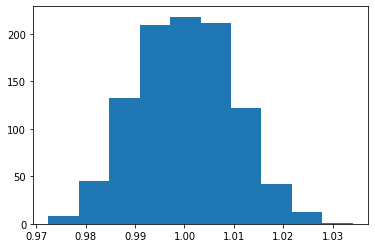

In [11]:
# if you want to see this
%matplotlib inline
plt.hist(co2_exc.random_sample(n=1000))

In [ ]:
# this in case you want to try with normal dist
#from stats_arrays import NormalUncertainty

#co2_exc['uncertainty type'] = NormalUncertainty.id
#co2_exc['loc'], co2_exc['scale'] = 1, 0.01
#co2_exc.save()
#co2_exc.uncertainty  # check that
#co2_exc.as_dict()  # OK

#  Now MC simulation

Sources here: [example](http://stackoverflow.com/questions/38532146/obtaining-distribution-of-results-from-lcia), [another example](https://brightwaylca.org/examples/getting-started.html), and [source code](https://bitbucket.org/cmutel/brightway2-calc/src/662740694a8c70074105b5dca45b58651adb5eb5/bw2calc/monte_carlo.py?at=default&fileviewer=file-view-default)

In [38]:
# Check again that uncertainty info is stored
list(el.exchanges())[0].uncertainty

{'uncertainty type': 2,
 'loc': 0.6931471805599453,
 'scale': 0.009950330853168092,
 'negative': True}

In [39]:
# This is the montecarlo simulation
mc = bw.MonteCarloLCA({el: 1000}, method_key)  # Monte Carlo class
mc_results = [next(mc) for x in range(500)] 

# two things here:
# next() is an iterator, a peculiar python construct, check it online
# using a fuction within [ ] usig a for loop is called a "list comprehension". The result is a list

In [40]:
mc_results

[79.914267145696,
 79.97592263897928,
 80.36779713583076,
 80.09121663396796,
 79.76437942611284,
 79.93295828508619,
 79.69221519959859,
 79.98630198808179,
 79.78605038768242,
 79.92068947415129,
 80.32840179154257,
 79.7225817519097,
 79.872700638986,
 79.6091800468338,
 79.87854552804387,
 80.03341989287665,
 79.97034876642147,
 80.05122645829331,
 80.14144915691807,
 80.20003905009403,
 79.9709732795663,
 79.878578992429,
 79.96456512839006,
 79.90306176357761,
 80.13678452849307,
 80.18518998342728,
 79.84476153816576,
 79.86853603666222,
 80.18481749568738,
 79.49027999485543,
 80.12883533759049,
 79.77153085409768,
 80.14426684202503,
 80.19295521298844,
 79.82195989507107,
 79.8761401933721,
 79.954685158865,
 79.86730536650511,
 79.66247420742602,
 80.34231919713253,
 79.93219908338716,
 79.84169185566512,
 79.89616655192552,
 79.914267145696,
 80.1935159520589,
 79.70254978566771,
 80.0912581849343,
 79.66309418937854,
 79.87891468518956,
 80.16039753909325,
 79.590582847457

Text(0.5, 0, 'lca.score')

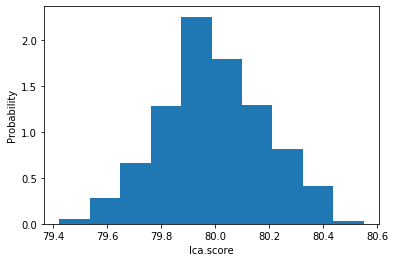

In [41]:
# Look at the MC results
plt.hist(mc_results, density=True)  # From matplotlib package. Use bins = int(500/15) to increase number of bars
plt.ylabel("Probability")
plt.xlabel('lca.score')

In [18]:
print(np.mean(mc_results)) # from numpy package
print(np.median(mc_results)) # from numpy package
print(lca.score)

119.981739495381
120.01153647873556
120.0


In [ ]:
119.97348875573454
119.94137661466638
120.0

In [19]:
pd.DataFrame(mc_results).describe()  # from pandas package

,0
count,500.000000
mean,119.981739
std,0.984836
min,116.890800
25%,119.254874
50%,120.011536
75%,120.632145
max,123.039791


Text(0.5, 0, 'lca.score')

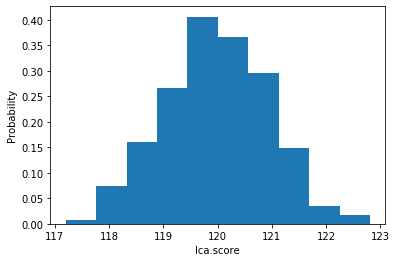

In [21]:
# Do this again and compare results
mc2 = bw.MonteCarloLCA({el: 1000}, method_key)  # Monte Carlo class
mc2_results = [next(mc2) for x in range(500)]

plt.hist(mc2_results, density=True)
plt.ylabel("Probability")
plt.xlabel('lca.score')

In [22]:
print(np.mean(mc2_results))
print(np.median(mc2_results))
print(lca.score)

119.98632565271778
119.97522480392288
120.0


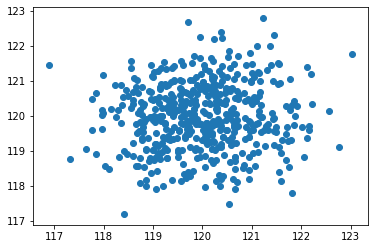

In [23]:
plt.scatter(mc_results, mc2_results) # Correct. Do you understand why?

In [28]:
# Another way to do it
iterations = 1000
scores = np.zeros([1, iterations])  # 1-dimensional array filled with zeros
for iteration in range(iterations):
    next(mc)
    scores[0, iteration] = mc.score
for i in range(1, 10):
    print(scores[0][i])  # need the zero because one-dimensional array

119.38748809682872
120.91535990460696
119.6273192820819
121.59594396601001
120.70296681240013
118.5156119729618
121.42675983021363
118.52751694488592
120.51577627618589


In [29]:
# Another way, get a list instead of an array
iterations = 1000
scores = []
for iteration in range(iterations):
    next(mc)
    scores.append(mc.score)
for i in range(1, 10):
    print(scores[i])
type(scores) == type(mc_results)  # same type of results as in the first case

121.34017161078404
121.79957781060483
121.33311744126456
119.67120654174335
119.64105243360642
118.83009890799428
117.77741355204722
121.05198195078754
119.80444083850837


True